In [1]:
import pandas as pd
import json
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loading the messages and runs data
runs_df = pd.read_csv(r"C:\Users\acer\Desktop\Infinity AI Work\InfinityStyleVerse\data\cleaned\synthetic_runs.csv", parse_dates=["started_at", "ended_at"])
messages_df = pd.read_csv(r"C:\Users\acer\Desktop\Infinity AI Work\InfinityStyleVerse\data\cleaned\synthetic_messages.csv", parse_dates=["created_at"])

# Converting JSON columns
runs_df["budget_json"] = runs_df["budget_json"].apply(json.loads)
runs_df["policy_json"] = runs_df["policy_json"].apply(json.loads)
messages_df["tools_json"] = messages_df["tools_json"].apply(json.loads)

# Displaying basic info
print("Runs Data Info:")
print(runs_df.info())
print("\nMessages Data Info:")
print(messages_df.info())

# Show first few rows
print("\nFirst 5 Runs:")
display(runs_df.head())
print("\nFirst 5 Messages:")
display(messages_df.head())

Runs Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           500 non-null    object        
 1   task         500 non-null    object        
 2   tenant       500 non-null    object        
 3   status       500 non-null    object        
 4   mode         500 non-null    object        
 5   budget_json  500 non-null    object        
 6   policy_json  500 non-null    object        
 7   started_at   500 non-null    datetime64[ns]
 8   ended_at     500 non-null    datetime64[ns]
 9   cost_cents   500 non-null    float64       
 10  latency_ms   500 non-null    int64         
 11  reward       500 non-null    float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(7)
memory usage: 47.0+ KB
None

Messages Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1726 entries, 0 to 1725
Data column

,id,task,tenant,status,mode,budget_json,policy_json,started_at,ended_at,cost_cents,latency_ms,reward
0,run_000,dynamic_pricing,tenant_b,succeeded,fast,"{'max_latency_ms': 1005, 'max_cost_cents': 12}","{'eco_min_score': 0.7, 'culture_check': True}",2025-09-07 11:02:07.734363,2025-09-07 11:28:03.734363,7.81,2172,0.07
1,run_001,design_recommendation,tenant_a,succeeded,fast,"{'max_latency_ms': 1607, 'max_cost_cents': 5}","{'eco_min_score': 0.7, 'culture_check': True}",2025-09-18 11:02:07.734363,2025-09-18 11:12:37.734363,2.34,1395,0.38
2,run_002,design_recommendation,tenant_c,succeeded,fast,"{'max_latency_ms': 1933, 'max_cost_cents': 14}","{'eco_min_score': 0.7, 'culture_check': True}",2025-09-26 11:02:07.735092,2025-09-26 11:26:58.735092,7.93,2172,0.11
3,run_003,dynamic_pricing,tenant_a,succeeded,fast,"{'max_latency_ms': 2709, 'max_cost_cents': 13}","{'eco_min_score': 0.7, 'culture_check': True}",2025-09-28 11:02:07.735092,2025-09-28 11:16:02.735092,7.00,695,0.25
4,run_004,dynamic_pricing,tenant_b,succeeded,thorough,"{'max_latency_ms': 1933, 'max_cost_cents': 5}","{'eco_min_score': 0.7, 'culture_check': True}",2025-09-09 11:02:07.735092,2025-09-09 11:12:54.735092,5.64,1191,0.72



First 5 Messages:


,id,run_id,turn,agent,role,content,tools_json,confidence,cost_cents,created_at
0,msg_run_000_0,run_000,0,TrendAgent,assistant,Sample output from TrendAgent...,"[{'name': 'TrendAgentTool.search', 'args': {'t...",0.71,0.62,2025-09-04 11:02:07.841765
1,msg_run_000_1,run_000,1,ElasticityAgent,assistant,Sample output from ElasticityAgent...,"[{'name': 'ElasticityAgentTool.search', 'args'...",0.63,0.63,2025-09-23 11:02:07.841765
2,msg_run_000_2,run_000,2,DemandAgent,assistant,Sample output from DemandAgent...,"[{'name': 'DemandAgentTool.search', 'args': {'...",0.67,1.92,2025-09-29 11:02:07.841765
3,msg_run_001_0,run_001,0,DemandAgent,assistant,Sample output from DemandAgent...,"[{'name': 'DemandAgentTool.search', 'args': {'...",0.61,0.64,2025-09-10 11:02:07.841765
4,msg_run_001_1,run_001,1,TrendAgent,assistant,Sample output from TrendAgent...,"[{'name': 'TrendAgentTool.search', 'args': {'t...",0.81,1.02,2025-09-20 11:02:07.842353


In [4]:
# Aggregating messages per run
messages_agg = messages_df.groupby("run_id").agg({
    "confidence": "mean",  
    "cost_cents": "sum",   # Total cost per run
    "tools_json": lambda x: [item for sublist in x for item in sublist],  # Flatten tool list
    "agent": lambda x: list(x.unique())  # List of unique agents
}).reset_index()

# Merging them with runs
merged_df = pd.merge(runs_df, messages_agg, left_on="id", right_on="run_id", how="left")

# Extracting the policy flags
merged_df["eco_min_score"] = merged_df["policy_json"].apply(lambda x: x.get("eco_min_score", 0.7))
merged_df["culture_check"] = merged_df["policy_json"].apply(lambda x: x.get("culture_check", True))

# Handling missing values
merged_df["confidence"].fillna(0.5, inplace=True)  # Default if no messages
merged_df["cost_cents_y"].fillna(0.0, inplace=True)  # Default if no messages
merged_df["tools_json"] = merged_df["tools_json"].apply(lambda x: x if isinstance(x, list) else [])  # Default empty list

# Displaying the merged data
print("Merged Data (First 5 Rows):")
display(merged_df.head())

# Saving
merged_df.to_csv("merged_synthetic_data.csv", index=False)

Merged Data (First 5 Rows):


,id,task,tenant,status,mode,budget_json,policy_json,started_at,ended_at,cost_cents_x,latency_ms,reward,run_id,confidence,cost_cents_y,tools_json,agent,eco_min_score,culture_check
0,run_000,dynamic_pricing,tenant_b,succeeded,fast,"{'max_latency_ms': 1005, 'max_cost_cents': 12}","{'eco_min_score': 0.7, 'culture_check': True}",2025-09-07 11:02:07.734363,2025-09-07 11:28:03.734363,7.81,2172,0.07,run_000,0.670000,3.17,"[{'name': 'TrendAgentTool.search', 'args': {'t...","[TrendAgent, ElasticityAgent, DemandAgent]",0.7,True
1,run_001,design_recommendation,tenant_a,succeeded,fast,"{'max_latency_ms': 1607, 'max_cost_cents': 5}","{'eco_min_score': 0.7, 'culture_check': True}",2025-09-18 11:02:07.734363,2025-09-18 11:12:37.734363,2.34,1395,0.38,run_001,0.710000,1.66,"[{'name': 'DemandAgentTool.search', 'args': {'...","[DemandAgent, TrendAgent]",0.7,True
2,run_002,design_recommendation,tenant_c,succeeded,fast,"{'max_latency_ms': 1933, 'max_cost_cents': 14}","{'eco_min_score': 0.7, 'culture_check': True}",2025-09-26 11:02:07.735092,2025-09-26 11:26:58.735092,7.93,2172,0.11,run_002,0.630000,2.28,"[{'name': 'StylistAgentTool.search', 'args': {...","[StylistAgent, ReturnRiskAgent]",0.7,True
3,run_003,dynamic_pricing,tenant_a,succeeded,fast,"{'max_latency_ms': 2709, 'max_cost_cents': 13}","{'eco_min_score': 0.7, 'culture_check': True}",2025-09-28 11:02:07.735092,2025-09-28 11:16:02.735092,7.00,695,0.25,run_003,0.805000,5.72,"[{'name': 'AggregatorTool.search', 'args': {'t...","[Aggregator, TrendAgent, ReturnRiskAgent]",0.7,True
4,run_004,dynamic_pricing,tenant_b,succeeded,thorough,"{'max_latency_ms': 1933, 'max_cost_cents': 5}","{'eco_min_score': 0.7, 'culture_check': True}",2025-09-09 11:02:07.735092,2025-09-09 11:12:54.735092,5.64,1191,0.72,run_004,0.783333,3.17,"[{'name': 'TrendAgentTool.search', 'args': {'t...","[TrendAgent, ElasticityAgent]",0.7,True



Reward Statistics:
count    500.000000
mean       0.333420
std        0.200569
min        0.000000
25%        0.200000
50%        0.355000
75%        0.400000
max        0.940000
Name: reward, dtype: float64


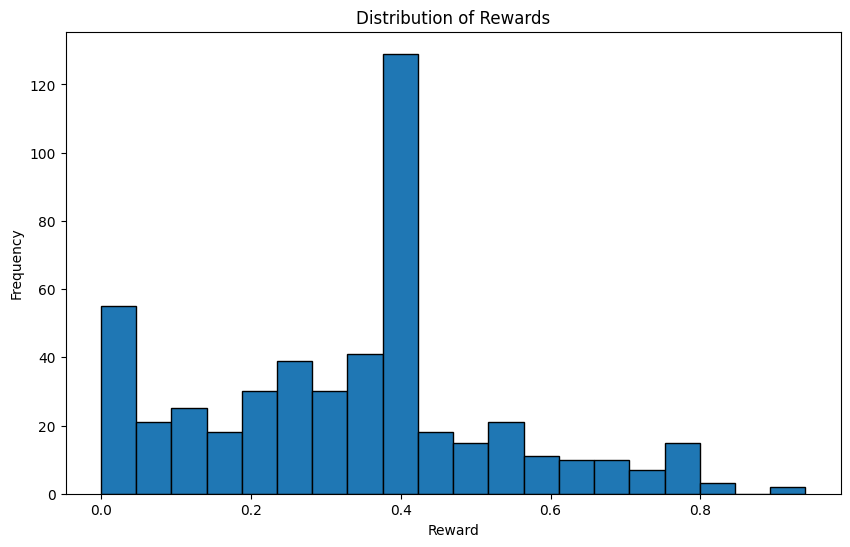

In [5]:
# Reward distribution
print("\nReward Statistics:")
print(merged_df["reward"].describe())

# Plotting a reward histogram
plt.figure(figsize=(10, 6))
plt.hist(merged_df["reward"], bins=20, edgecolor='black')
plt.title("Distribution of Rewards")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.show()